# FINM 25000

### Review Notes 3 - Python Helper Guide

##### 7/1/2022

### Smart Beta ETFs and Factor Beta Investing

### Quick-Recap

Last week we discussed the following items:

1. Portfolio Summary Statistics and Mean Variance Optimization
<br>

2. Tail Risk Measures
    - Skewness
    - Kurtosis
    - Maximum Drawdown
    - VaR
    - CVaR

3. Regression
    - How to run a Linear Regression!
    - Relative performance (Treynor Ratio, Info Ratio, Tracking Error)
    - Hedging and Tracking
    

This week, we will discuss Factor Pricing models and how do we test if a particular factor model performs well or not. We will also discuss what Pricing Factors are and how they are created as discussed in the case. Finally, we will end with a discussion on how to implement these techniques in Python. A lot of what we are going to cover this week will be derived from the regression concepts discussed in the last session so please make sure to review that on Canvas. But first let's cover the basics. 

In [1]:
# Start by importing the packages and datasets for this week's homework

import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


factors = pd.read_excel('factor_pricing_data.xlsx', 'factors (excess)').set_index("Date")
portfolios = pd.read_excel('factor_pricing_data.xlsx', 'assets (excess)').set_index("Date")

In [2]:
print('*** Factor Data ***')
display(factors.head())
print(' ')
print('*** Portfolio Data ***')
display(portfolios.head())

*** Factor Data ***


,MKT,SMB,HML,UMD
Date,,,,
1990-01-31,-0.079,-0.013,0.009,-0.033
1990-02-28,0.011,0.010,0.006,-0.005
1990-03-31,0.018,0.015,-0.029,0.018
1990-04-30,-0.034,-0.005,-0.026,0.024
1990-05-31,0.084,-0.026,-0.038,0.030


 
*** Portfolio Data ***


,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
1990-01-31,-0.100,-0.044,-0.062,-0.049,-0.086,-0.018,-0.140,-0.059,-0.070,-0.079,-0.103,-0.079
1990-02-28,-0.010,0.046,0.021,0.025,0.016,0.035,-0.009,-0.004,0.014,-0.026,0.018,0.024
1990-03-31,0.039,0.023,0.040,-0.012,0.016,0.038,0.035,-0.014,0.045,0.032,-0.022,0.013
1990-04-30,-0.010,-0.047,-0.036,-0.042,-0.029,-0.027,-0.042,-0.062,-0.028,-0.004,-0.049,-0.029
1990-05-31,0.084,0.071,0.071,0.053,0.082,0.119,0.087,0.047,0.110,0.121,0.086,0.082


## Small Detour: Visualizations

Let's plot the return on various factors to see which factors have performed well over time. We will use the matplotlib library to create the visulaizations

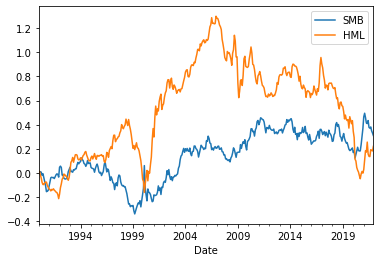

In [9]:
# Let's calculate the cumulative returns of the factors table, to do this we will use the .cumprod method
# r = (1+r_1)*(1+r_1)*...*(1+r_i) - 1
cum_rets = (1+factors).cumprod() - 1

# To plot these series use the .plot function. Notice that the .plot function is used with a pandas dataframe
cum_rets[['SMB', 'HML']].loc[:'2021'].plot()
plt.show()

Another useful visualization in this course will be scatter plot, they are helpful in determining linear relationships between two data series. Let's use the .scatter method to look at the relationship between SMB and HML returns

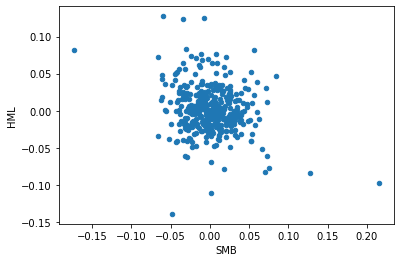

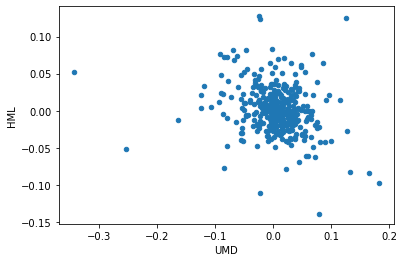

In [5]:
# Use the factors data to compare the relationship between SMB and HML. Use the .plot.scatter() method to create the scatter plot

factors.plot.scatter('SMB', 'HML')
plt.show()

# Now let's also look at the relationship between CMA and HML

factors.plot.scatter('UMD', 'HML')
plt.show()


To read more about matplotlib and plotting in pandas, please look at the following links:

    1. https://pandas.pydata.org/docs/user_guide/visualization.html
    2. https://matplotlib.org/
    3. https://matplotlib.org/cheatsheets/

## Back to the Case: Let's look at how to analyze the portfolio metrics

,Mean,Vol,Sharpe,Min,Max
NoDur,0.086,0.132,0.651,-0.134,0.142
Durbl,0.106,0.270,0.394,-0.330,0.453
Manuf,0.101,0.185,0.547,-0.237,0.208
Enrgy,0.087,0.220,0.395,-0.346,0.324
Chems,0.086,0.148,0.581,-0.157,0.126
BusEq,0.125,0.235,0.531,-0.264,0.203
Telcm,0.055,0.175,0.313,-0.163,0.212
Utils,0.075,0.138,0.543,-0.131,0.112
Shops,0.097,0.161,0.603,-0.152,0.180
Hlth,0.097,0.153,0.633,-0.127,0.162


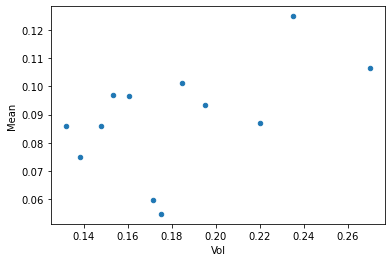

In [6]:
# We will use the performaceMetrics function again which we introduced last session

#Mean, Volatality and Sharpe Ratio

def performanceMetrics(returns,annualization=1, quantile=.05):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    return metrics

perform_metrics = performanceMetrics(portfolios, annualization = 12)
display(perform_metrics)

perform_metrics.plot.scatter('Vol', 'Mean')
plt.show()

The plot above shows the mean excess return and it's relationship with volatality. It appears that investors care about something more than the variance of a security. If they just cared about that, the graph above would be a continously increasing function close to a straight line. The homework asks you to see if there are any other statistics that can be used to justify the price/return of the security.

In [7]:
# To Look at the tail metrics:

#VaR, CVaR, Max Drawdown
def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    
    #Maximum Drawdown
    def maximumDrawdown(returns):
        cum_returns = (1 + returns).cumprod()
        rolling_max = cum_returns.cummax()
        drawdown = (cum_returns - rolling_max) / rolling_max

        max_drawdown = drawdown.min()
        end_date = drawdown.idxmin()
        summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

        for col in drawdown:
            summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
            recovery = (drawdown.loc[end_date[col]:,col])
            try:
                summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
            except:
                summary.loc[col,'Recover'] = pd.to_datetime(None)

            summary['Peak'] = pd.to_datetime(summary['Peak'])
            try:
                summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
            except:
                summary['Duration (to Recover)'] = None

            summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

        return summary  
    
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    if mdd:
        mdd_stats = maximumDrawdown(returns)
        metrics = metrics.join(mdd_stats)

        if relative:
            metrics['Max Drawdown'] = (metrics['Max Drawdown'] - returns.mean())/returns.std()

    return metrics


tail_metrics = tailMetrics(portfolios)
tail_metrics

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
NoDur,-0.401,1.100,-0.057,-0.083,-0.350,2007-11-30,2009-02-28,2010-09-30,1035 days
Durbl,0.840,5.961,-0.112,-0.153,-0.785,1999-04-30,2009-02-28,2013-09-30,5267 days
Manuf,-0.595,2.391,-0.084,-0.125,-0.602,2007-10-31,2009-02-28,2011-03-31,1247 days
Enrgy,0.106,4.702,-0.095,-0.134,-0.664,2014-06-30,2020-03-31,2022-03-31,2831 days
Chems,-0.337,0.917,-0.072,-0.093,-0.442,2007-12-31,2009-02-28,2010-10-31,1035 days
BusEq,-0.371,1.180,-0.111,-0.150,-0.814,2000-03-31,2002-09-30,2017-07-31,6331 days
Telcm,-0.304,1.361,-0.090,-0.118,-0.778,1999-12-31,2009-02-28,2017-01-31,6241 days
Utils,-0.547,0.825,-0.063,-0.088,-0.392,2007-10-31,2009-02-28,2011-10-31,1461 days
Shops,-0.196,0.859,-0.072,-0.098,-0.409,2007-05-31,2009-02-28,2010-12-31,1310 days
Hlth,-0.160,0.300,-0.073,-0.088,-0.426,2000-12-31,2009-02-28,2012-04-30,4138 days


## Time Series CAPM

CAPM asserts that an asset's expected excess return is completely a function of it's beta to the market portfolio.

Mathematically,

$$
\mathbb{E}[r^i] = \beta^{i,mkt}*\mathbb{E}[r^{mkt}]
$$

To test this, we will run a time-series regression of the form:

$$
r^i_t = \alpha^i + \beta^{i,mkt} * r^{mkt}_t + \epsilon^i_t
$$

where $i$ represents a security and $t$ represents an observation time. Remember the discussion in the class about why $\alpha_i$ = 0 in population for CAPM to hold.

In [10]:
def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y,lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

In [11]:
coef_table = get_ols_metrics(factors['MKT'], portfolios, annualization=1, ignorenan=True)
display(coef_table)

,alpha,MKT,r-squared,Treynor Ratio,Info Ratio
NoDur,0.003,0.631,0.529,0.011,0.104
Durbl,-0.001,1.361,0.585,0.007,-0.014
Manuf,0.001,1.103,0.823,0.008,0.030
Enrgy,0.001,0.844,0.339,0.009,0.026
Chems,0.002,0.766,0.619,0.009,0.067
BusEq,0.001,1.335,0.743,0.008,0.030
Telcm,-0.002,0.924,0.642,0.005,-0.064
Utils,0.003,0.409,0.202,0.015,0.095
Shops,0.002,0.894,0.716,0.009,0.072
Hlth,0.003,0.721,0.510,0.011,0.097


In [12]:
# To calculate the Mean-Absolute-Error

mean_abs_err = coef_table.alpha.mean()
print('Mean Absolute Error: {:,.4f}'.format(mean_abs_err * 12))

Mean Absolute Error: 0.0108


<AxesSubplot:xlabel='MKT', ylabel='Mean'>

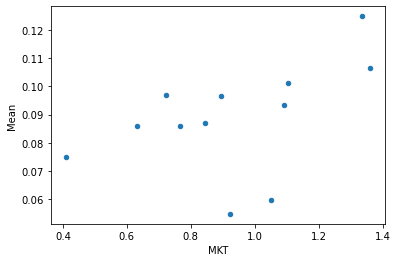

In [13]:
pd.concat([perform_metrics[['Mean']], coef_table[['MKT']]], axis = 1).plot.scatter('MKT', 'Mean')

## Multi factor Model

Let's extend the CAPM theory to multiple factors. We introduce the SMB, HML and the UMB factor. Can you define these factors and their respective construction methods? These are introduced in great detail in the case this week and will be discussed at length in the next lecture.

Say that the following equation holds:

$$
\mathbb{E}[r^i] = \beta^{i,mkt}*\mathbb{E}[r^{mkt}] + \beta^{i,smb}*\mathbb{E}[r^{smb}] + \beta^{i,hml}*\mathbb{E}[r^{hml}] + \beta^{i,umd}*\mathbb{E}[r^{umd}]
$$


Then, the following regressions should produce $\alpha_i = 0$

$$
r^i_t = \alpha^i + \beta^{i,mkt} * r^{mkt}_t +  \beta^{i,smb} * r^{smb}_t + \beta^{i,hml} * r^{hml}_t + \beta^{i,umd} * r^{umd}_t + \epsilon^i_t
$$

In [14]:
coef_table = get_ols_metrics(factors, portfolios, annualization=1, ignorenan=True)
display(coef_table)

,alpha,MKT,SMB,HML,UMD,r-squared,Info Ratio
NoDur,0.002,0.693,-0.224,0.181,0.018,0.593,0.088
Durbl,0.000,1.283,0.226,0.390,-0.253,0.645,0.005
Manuf,0.001,1.090,0.099,0.267,-0.072,0.857,0.030
Enrgy,-0.000,0.895,0.100,0.664,0.013,0.444,-0.004
Chems,0.001,0.813,-0.170,0.212,-0.012,0.668,0.055
BusEq,0.003,1.207,0.183,-0.643,-0.115,0.842,0.121
Telcm,-0.001,0.933,-0.168,-0.036,-0.057,0.654,-0.050
Utils,0.002,0.513,-0.219,0.312,0.119,0.304,0.055
Shops,0.002,0.895,-0.032,-0.006,-0.015,0.717,0.077
Hlth,0.003,0.761,-0.196,-0.151,0.066,0.542,0.095


## Extensions (Optional)

The extension question asks you to calculate the cross-sectional regression. Given a set of securities and their betas, we run the regression to understand the relationship between betas and expected returns. If a factor pricing model is true, this regression should be perfect in population, and atleast nearly perfect in sample. To do this you may use the helper function available below:

In [15]:
def cross_section(df, factor_df, factors, ts_int=True, annualization=12):
    
    def ts_betas(df, factor_df, factors, intercept=False, return_resid = False):
        if intercept == True:
            res = pd.DataFrame(data = None, index = df.columns, columns = ['alpha'])
            res[factors] = None
        else:
            res = pd.DataFrame(data = None, index = df.columns, columns = factors)

        if return_resid == True:
            res_resid = pd.DataFrame(index = df.index, columns = df.columns) 

        for port in df.columns:
            y = df[port]
            if intercept == True:
                X = sm.add_constant(factor_df[factors])
            else:
                X = factor_df[factors]
            model = sm.OLS(y, X).fit()
            if intercept == True:
                res.loc[port, 'alpha'] = model.params['const']
                res.loc[port, factors] = model.params[factors]
                res.loc[port, 'RSQ'] = model.rsquared
            else:
                res.loc[port, factors] = model.params[factors]
                res.loc[port, 'RSQ'] = model.rsquared

            if return_resid == True:
                res_resid[port] = model.resid


        if return_resid == True:
            return res , res_resid
        else:
            return res
    
    betas = ts_betas(df, factor_df, factors, intercept=ts_int)
    res = pd.DataFrame(data = None, index = betas.index, columns = factors)
    res['Predicted'] = None
    res['Actual'] = None
    
    for port in res.index:
        res.loc[port, factors] = betas.loc[port]
        prem = (betas.loc[port] * factor_df[factors]).sum(axis=1).mean() * annualization
        res.loc[port,['Predicted','Actual']] = prem, df[port].mean() * annualization
        
    endog = np.asarray(res['Actual'], dtype='float')
    exog = sm.add_constant(np.array(betas[factors], dtype='float'))
    
    model = sm.regression.linear_model.OLS(endog, exog).fit()
    
    return res, model.params, model.rsquared

In [16]:
res, model_params, model_rsquared = cross_section(portfolios, factors, ['MKT', 'HML', 'SMB', 'UMD'], ts_int=True, annualization=12)
print(model_params)
print(model_rsquared)

[ 0.06683807  0.02814166 -0.01572614  0.0274043   0.02094325]
0.29946317489645
